In [3]:
import os
import torch
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt 
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image,ImageDraw,ImageFont
from torchmetrics import Accuracy,F1Score
from torchvision.datasets import ImageFolder

Constants

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TRAIN_PATH = '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training'
TEST_PATH = '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Testing'
BATCH_SIZE = 32
IMG_SIZE = (244,244)

i2c = {
    0:'glioma',
    1:'meningioma',
    2:'notumor',
    3:'pituitary'
}
c2i = {v:k for k,v in i2c.items()}

In [5]:
def get_rand_paths(path,num):
    folders = os.listdir(path)
    result = []
    for i in range(num):
        folder = np.random.choice(folders)
        name = np.random.choice(os.listdir(f'{path}/{folder}'))
        full_path = f'{path}/{folder}/{name}'
        result.append(full_path)
    return result

In [6]:
def tag(img,y,pred):
    resized = img.resize(IMG_SIZE).convert('RGB')
    draw = ImageDraw.Draw(resized)

    font = ImageFont.truetype('/kaggle/input/font/other/default/1/Exo-Bold.otf',15)
    bbox_color = (0,255,0)
    if y!=pred:
        bbox_color = (255,0,0)
    
    bbox_padd = 4
    text_point = (15,10)
    
    bbox = draw.textbbox(text_point,i2c[pred],font=font)
    padded_box = (
        bbox[0]-bbox_padd,
        bbox[1]-bbox_padd,
        bbox[2]+bbox_padd,
        bbox[3]+bbox_padd
    )
    
    draw.rectangle(padded_box,outline=bbox_color)
    draw.text(text_point,i2c[pred],font=font)
    return resized

In [7]:
def show_samples(imgs,y=None,pred=None):
    cols = 3
    rows = int(np.ceil(imgs.shape[0]/cols))
    padd = 15
    width =  (IMG_SIZE[0] + padd) * cols
    height = (IMG_SIZE[1] + padd) * rows
    grid = Image.new('RGB',(width,height))
    
    
    col_counter = 0
    left = padd
    top = padd
    for i in range(imgs.shape[0]):
        img = Image.fromarray(imgs[i]).resize(IMG_SIZE)
        if y and pred:
            img = tag(img,y[i],pred[i])
                
        if col_counter==cols:
            col_counter = 0 
            left = 0
            top += (IMG_SIZE[1] + padd)
        
        grid.paste(img,(left,top))
        
        left += (IMG_SIZE[0] + padd)
        col_counter += 1
        
    return grid

In [8]:
def rand_samples(num=9):
    folders = os.listdir(TRAIN_PATH)
    imgs = []
    targets = []
    for n in range(num):
        folder = np.random.choice(folders)
        name = np.random.choice(os.listdir(f'{TRAIN_PATH}/{folder}'))
        img = Image.open(f'{TRAIN_PATH}/{folder}/{name}').resize(IMG_SIZE)
        imgs.append(img)
        targets.append(c2i[folder])

    return show_samples(np.array(imgs),targets,targets)

In [9]:
def example(model,transformer,folder_path=TEST_PATH,num=9):
    paths = get_rand_paths(folder_path,num)
    imgs = []
    targets = []

    for path in paths:
        img = Image.open(path).resize(IMG_SIZE)
        target = c2i[path.split('/')[-2]]

        imgs.append(img)
        targets.append(target)

    transformed = torch.stack([transformer(img.convert('RGB')) for img in imgs]).to(device)
    with torch.no_grad():
        pred = model(transformed).tolist()
    pred = np.argmax(pred,1)
    
    return show_samples(np.array(imgs),targets,pred.tolist())

Data understanding

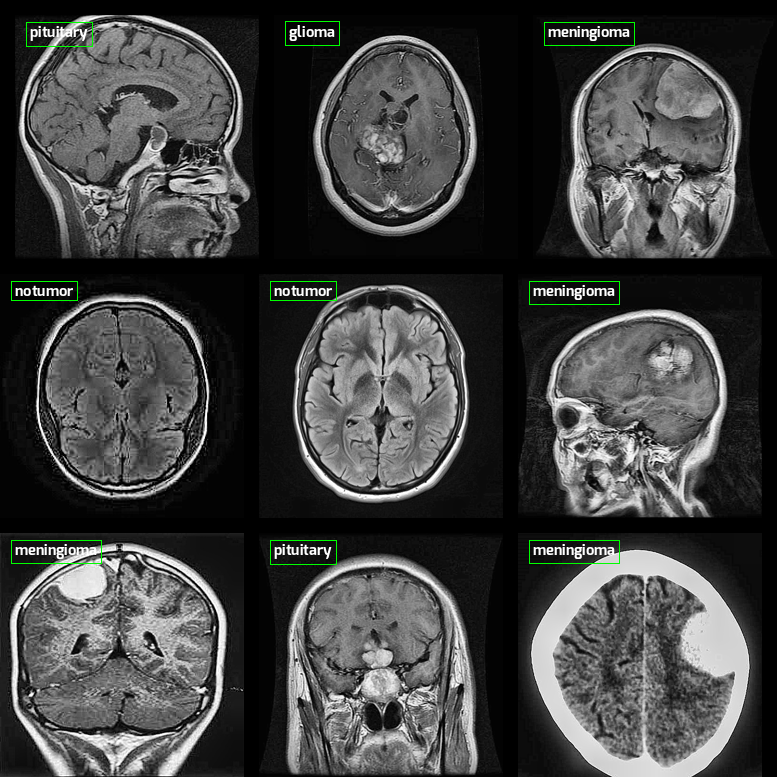

In [10]:
# Random samples from training folder
rand_samples(9)

{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}


<BarContainer object of 4 artists>

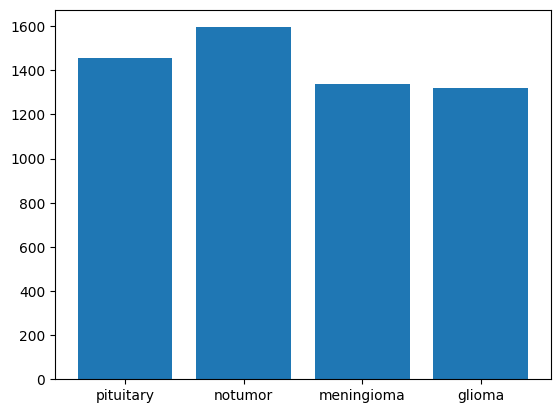

In [11]:
# Destribution of data
des = {i:len(os.listdir(os.path.join(TRAIN_PATH,i))) for i in os.listdir(TRAIN_PATH)}
print(des)
plt.bar(des.keys(),des.values())

Loading & Preparing data

In [12]:
transform = T.Compose([
    T.RandomCrop(int(IMG_SIZE[0]/3)),
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(p=0.2),
    T.RandomVerticalFlip(p=0.2),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

eval_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [13]:
totalset = ImageFolder(TRAIN_PATH,transform)
train_size = int(.8 *len(totalset))
val_size = len(totalset) - train_size

trainset,valset = random_split(totalset,[train_size,val_size])
testset = ImageFolder(TEST_PATH,eval_transform)

valset.dataset.transform = eval_transform
print(f'Train size: {train_size}\nValidation size: {val_size}\nTest size: {len(testset)}')

Train size: 4569
Validation size: 1143
Test size: 1311


In [14]:
train_loader = DataLoader(trainset,BATCH_SIZE)
test_loader = DataLoader(testset,BATCH_SIZE)
val_loader = DataLoader(valset,BATCH_SIZE)

In [15]:
# Testing data loader
for img,lbl in train_loader:
    print(img.shape)
    print(lbl)
    break

torch.Size([32, 3, 244, 244])
tensor([3, 0, 0, 3, 2, 2, 3, 3, 3, 2, 1, 2, 2, 2, 1, 0, 0, 3, 2, 1, 2, 3, 3, 1,
        0, 3, 0, 0, 3, 1, 0, 1])


Preparing Model

In [16]:
def get_model(unfreeze=8):
    resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    total_layers = len(list(resnet.parameters()))
    
    for i,p in enumerate(resnet.parameters()):
        p.requires_grad = False
        if i > (total_layers-unfreeze):
            p.requires_grad = True
            
    resnet.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(2048,len(i2c)))
    
    total = sum([p.numel() for p in resnet.parameters()])
    trainable = sum([p.numel() for p in resnet.parameters() if p.requires_grad])
    print(f'Total Params: {total}')
    print(f'Trainable Params: {trainable}')
    return resnet.to(device)

In [17]:
class_weights = torch.tensor(list(des.values())) / torch.sum(torch.tensor(list(des.values())))

In [18]:
model = get_model(unfreeze = 5)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(class_weights.to(device))
accuracy = Accuracy('multiclass',num_classes=len(c2i)).to(device)
f1_score = F1Score('multiclass',num_classes=len(c2i)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Total Params: 23516228
Trainable Params: 12292


Training and evaluation

In [19]:
def train_step(loader,model,optim,criterion,acc,f1):
    model.train()
    total_loss = 0 
    for i,(imgs,labels) in enumerate(loader):
        imgs,labels = imgs.to(device), labels.to(device)
        optim.zero_grad(True)
        logits = model(imgs)
        loss = criterion(logits,labels)
        loss.backward()
        optim.step()
        
        acc.update(logits,labels)
        f1.update(logits,labels)
        total_loss += loss
    
    total_loss /= (i+1)
    total_acc = acc.compute()
    total_f1 = f1.compute()

    if i%50==0:
        print(f'Train:\nLoss: {total_loss.item():.2f}\tAccuracy: {total.acc.item():.2f}\tF1 score: {total_f1.item():.2f}')
    
    f1.reset()
    acc.reset()
    return total_loss,total_acc,total_f1

In [20]:
def val_step(loader,model,criterion,acc,f1):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for i,(imgs,labels) in enumerate(loader):
            imgs,labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits,labels)
            acc.update(logits,labels)
            f1.update(logits,labels)
            total_loss += loss
        
        total_loss /= (i+1)
        total_acc = acc.compute()
        total_f1 = f1.compute()
        
        f1.reset()
        acc.reset()
    return total_loss,total_acc,total_f1

In [21]:
metrics = {'loss':[],'val_loss':[],'acc':[],'val_acc':[],'f1':[],'val_f1':[]}
best_acc = 0
for epoch in range(5):
    loss,train_acc,train_f1 = train_step(train_loader,model,optimizer,criterion,accuracy,f1_score)
    val_loss,val_acc,val_f1 = val_step(val_loader,model,criterion,accuracy,f1_score)
    
    metrics['loss'].append(loss.item())
    metrics['val_loss'].append(val_loss.item())
    metrics['acc'].append(train_acc.item())
    metrics['val_acc'].append(val_acc.item())
    metrics['f1'].append(train_f1.item())
    metrics['val_f1'].append(val_f1.item())

    if val_acc > best_acc:
        torch.save(model.state_dict(),'best.pth')
    
    checkpoint = {
          'epoch':epoch,
          'optimizer':optimizer.state_dict(),
          'model':model.state_dict(),
          'loss':val_loss.item(),
          'accuracy':val_acc.item()
        }
    torch.save(checkpoint,f'checkpoint{epoch}.pth')
    best_acc = val_acc.item()
    print(f'Loss: {loss.item():.2f}\tVal loss: {val_loss.item():.2f}\tAccuracy: {train_acc.item():.2f}\tVal accuracy: {val_acc:.2f}')

Loss: 0.57	Val loss: 0.39	Accuracy: 0.82	Val accuracy: 0.90
Loss: 0.38	Val loss: 0.32	Accuracy: 0.88	Val accuracy: 0.91
Loss: 0.32	Val loss: 0.29	Accuracy: 0.89	Val accuracy: 0.91
Loss: 0.28	Val loss: 0.26	Accuracy: 0.91	Val accuracy: 0.91
Loss: 0.26	Val loss: 0.25	Accuracy: 0.91	Val accuracy: 0.92


# **Test on unseen data**

In [22]:
val_loss,val_acc,val_f1 = val_step(test_loader,model,criterion,accuracy,f1_score)
print(f'Results on unseen data:\n\t* Loss: {val_loss.item():.2f}\n\t* Accuracy: {val_acc.item():.2f}\n\t* F1 Score: {val_f1.item():.2f}')

Results on unseen data:
	* Loss: 0.29
	* Accuracy: 0.89
	* F1 Score: 0.89


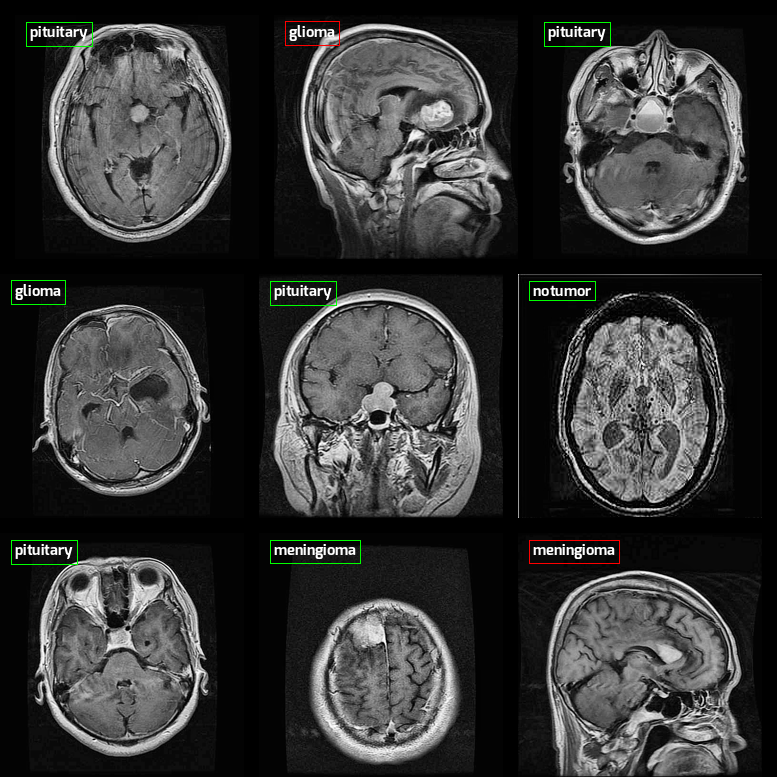

In [26]:
example(model,eval_transform,TEST_PATH,9)